In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
np.random.seed(1)

def hyperbolic(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def generate_neurons_uniform(X,num_neurons):
    k = X.shape[1]
    variances = np.std(X,axis=0)
    weights = []
    for i in range(k):
        λ = variances[i]/np.sum(variances)
        a = 2.5 * λ / np.max(np.abs(X[:,i]))
        weight = np.random.uniform(low=-a,high=a,size=num_neurons)
        weights.append(weight)
    weights = np.array(weights)
    intercept = np.random.uniform(low=-1,high=1,size=num_neurons)
    
    return weights, intercept

def cal_neuron_val(X, weights, intercept):
    neuron_val = np.matmul(X,weights) + intercept
    neuron_val = hyperbolic(neuron_val)
    return neuron_val

def mbelm_ensemble(data,coordinate,num_neurons=3, ensemble_num = 50):
    ensemble_weights = []
    ensemble_intercept = []
    ensemble_model = []
    
    for i in range(ensemble_num):
    
        weights, intercept = generate_neurons_uniform(data[['Mean Curvature','Mean Angle']].values,
                                                      num_neurons=num_neurons)
        neuron_val = cal_neuron_val(data[['Mean Curvature','Mean Angle']].values,weights,intercept)

        # Fit the output layer
        clf = BayesianRidge()
        name = 'Pointwise Variance ' + coordinate
        clf.fit(neuron_val, data[name].values)
        
        ensemble_weights.append(weights)
        ensemble_intercept.append(intercept)
        ensemble_model.append(clf)
    
    return {'weight':ensemble_weights,'intercept':ensemble_intercept, 
            'model':ensemble_model, "num": ensemble_num}

def mbelm_pred_ensemble(train,model):
    prediction = 0
    for i in range(model['num']):
        neuron_pred = cal_neuron_val(train[['Mean Curvature','Mean Angle']].values, 
                                     model['weight'][i],
                                     model['intercept'][i])
        prediction += model['model'][i].predict(neuron_pred)
        
    prediction = prediction/model['num']
    
    return prediction

In [2]:
# Training sets
ball = pd.read_csv('Half Ball Prediction Data.csv')
convex = pd.read_csv('Convex Prediction Data.csv')
freeform = pd.read_csv('Freeform 2 Prediction Data.csv')

ball['Pointwise Variance X'] = np.log(ball['Pointwise Variance X'])
ball['Pointwise Variance Y'] = np.log(ball['Pointwise Variance Y'])
ball['Pointwise Variance Z'] = np.log(ball['Pointwise Variance Z'])

convex['Pointwise Variance X'] = np.log(convex['Pointwise Variance X'])
convex['Pointwise Variance Y'] = np.log(convex['Pointwise Variance Y'])
convex['Pointwise Variance Z'] = np.log(convex['Pointwise Variance Z'])

freeform['Pointwise Variance X'] = np.log(freeform['Pointwise Variance X'])
freeform['Pointwise Variance Y'] = np.log(freeform['Pointwise Variance Y'])
freeform['Pointwise Variance Z'] = np.log(freeform['Pointwise Variance Z'])

# Fit model
ball_x = mbelm_ensemble(ball,'X')
ball_y = mbelm_ensemble(ball,'Y')
ball_z = mbelm_ensemble(ball,'Z')

convex_x = mbelm_ensemble(convex,'X')
convex_y = mbelm_ensemble(convex,'Y')
convex_z = mbelm_ensemble(convex,'Z')

freeform_x = mbelm_ensemble(freeform,'X')
freeform_y = mbelm_ensemble(freeform,'Y')
freeform_z = mbelm_ensemble(freeform,'Z')

In [3]:
# Ball
ball_nominal = pd.read_csv("point_clouds/nominal_ball.csv")
ball_diff = pd.read_csv("scan_to_nominal_diff_ball.csv")

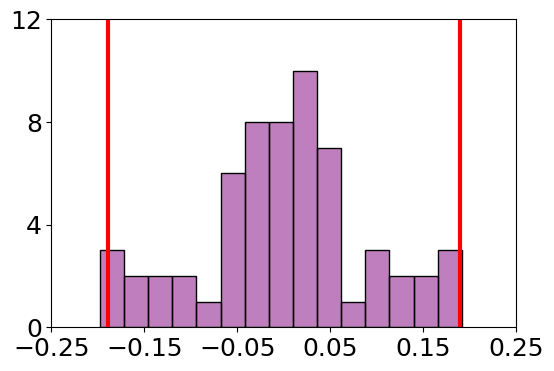

In [4]:
plt.style.use("default")

plt.figure(figsize=(6,4))

ball_x_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(ball,ball_x))))

sns.histplot(ball_diff['X'], bins=15, color="purple", alpha=0.5)
plt.axvline(x=3*ball_x_sigma, lw=3, color="red")
plt.axvline(x=-3*ball_x_sigma, lw=3, color="red")

plt.xticks(np.arange(-0.25, 0.251, step=0.1), fontsize=18)
plt.yticks(np.arange(0, 12.1, step=4), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("ball_x_diff.png", bbox_inches='tight', dpi=1000)

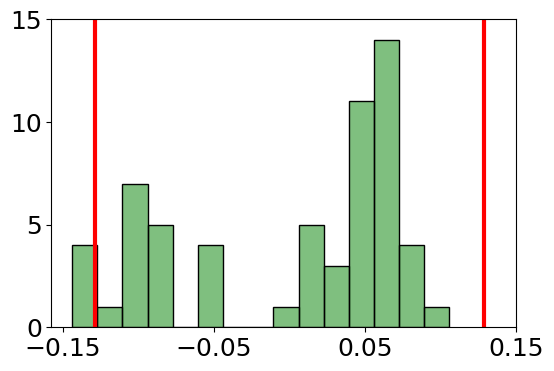

In [5]:
plt.figure(figsize=(6,4))

ball_y_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(ball,ball_y))))

plt.style.use("default")

sns.histplot(ball_diff['Y'], bins=15, color="green", alpha=0.5)
plt.axvline(x=3*ball_y_sigma, lw=3, color="red")
plt.axvline(x=-3*ball_y_sigma, lw=3, color="red")

plt.xticks(np.arange(-0.15, 0.151, step=0.1), fontsize=18)
plt.yticks(np.arange(0, 15.1, step=5), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("ball_y_diff.png", bbox_inches='tight', dpi=1000)

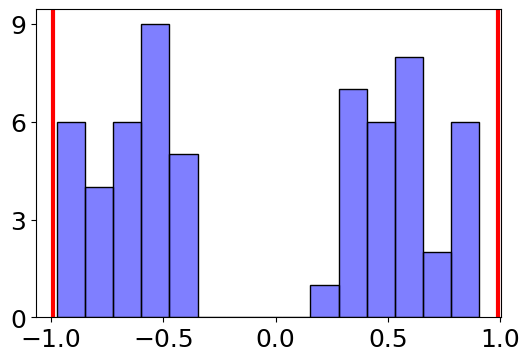

In [6]:
plt.figure(figsize=(6,4))

ball_z_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(ball,ball_z))))

plt.style.use("default")

sns.histplot(ball_diff['Z'], bins=15, color="blue", alpha=0.5)
plt.axvline(x=3*ball_z_sigma, lw=3, color="red")
plt.axvline(x=-3*ball_z_sigma, lw=3, color="red")

plt.xticks(np.arange(-1, 1.01, step=0.5), fontsize=18)
plt.yticks(np.arange(0, 9.1, step=3), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("ball_z_diff.png", bbox_inches='tight', dpi=1000)

In [7]:
# Convex
convex_nominal = pd.read_csv("point_clouds/nominal_convex.csv")
convex_diff = pd.read_csv("scan_to_nominal_diff_convex.csv")

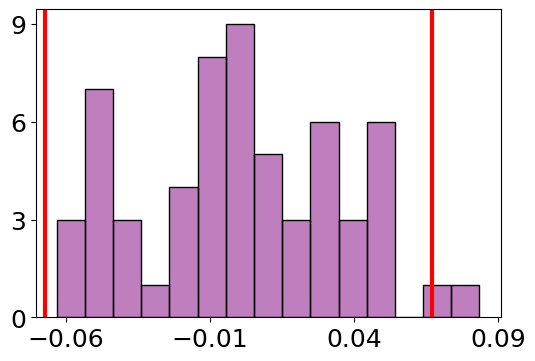

In [8]:
plt.figure(figsize=(6,4))

convex_x_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(convex,convex_x))))
plt.style.use("default")

sns.histplot(convex_diff['X'], bins=15, color="purple", alpha=0.5)
plt.axvline(x=3*convex_x_sigma, lw=3, color="red")
plt.axvline(x=-3*convex_x_sigma, lw=3, color="red")

plt.xticks(np.arange(-0.06, 0.091, step=0.05), fontsize=18)
plt.yticks(np.arange(0, 9.1, step=3), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("convex_x_diff.png", bbox_inches='tight', dpi=1000)

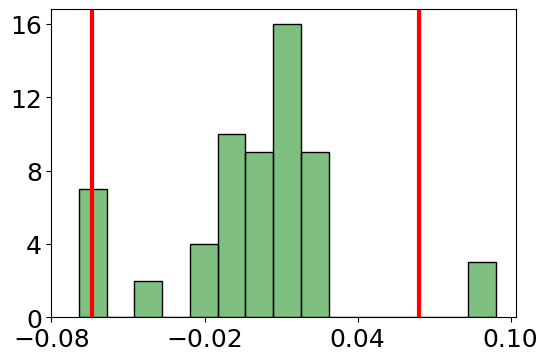

In [9]:
plt.figure(figsize=(6,4))

convex_y_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(convex,convex_y))))
plt.style.use("default")

sns.histplot(convex_diff['Y'], bins=15, color="green", alpha=0.5)
plt.axvline(x=3*convex_y_sigma, lw=3, color="red")
plt.axvline(x=-3*convex_y_sigma, lw=3, color="red")

plt.xticks(np.arange(-0.08, 0.11, step=0.06), fontsize=18)
plt.yticks(np.arange(0, 17, step=4), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("convex_y_diff.png", bbox_inches='tight', dpi=1000)

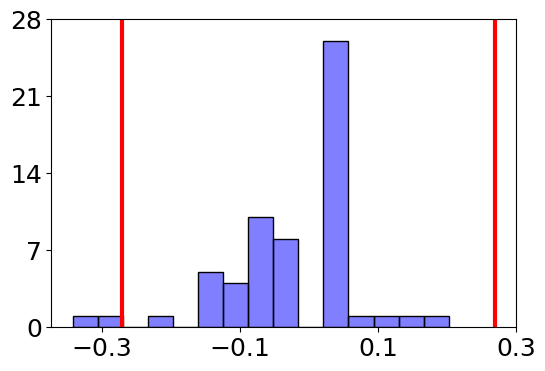

In [10]:
plt.figure(figsize=(6,4))

convex_z_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(convex,convex_z))))
plt.style.use("default")

sns.histplot(convex_diff['Z'], bins=15, color="blue", alpha=0.5)
plt.axvline(x=3*convex_z_sigma, lw=3, color="red")
plt.axvline(x=-3*convex_z_sigma, lw=3, color="red")

plt.xticks(np.arange(-0.3, 0.31, step=0.2), fontsize=18)
plt.yticks(np.arange(0, 28.1, step=7), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("convex_z_diff.png", bbox_inches='tight', dpi=1000)

In [11]:
# Freeform
freeform_nominal = pd.read_csv("point_clouds/nominal_freeform.csv")
freeform_diff = pd.read_csv("scan_to_nominal_diff_freeform.csv")

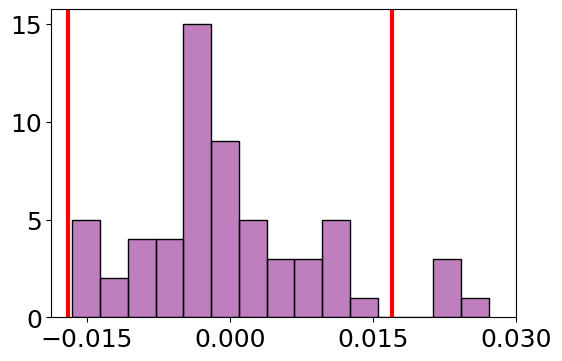

In [12]:
plt.figure(figsize=(6,4))

freeform_x_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(freeform,freeform_x))))
plt.style.use("default")

sns.histplot(freeform_diff['X'], bins=15, color="purple", alpha=0.5)
plt.axvline(x=3*freeform_x_sigma, lw=3, color="red")
plt.axvline(x=-3*freeform_x_sigma, lw=3, color="red")

plt.xticks(np.arange(-0.015, 0.031, step=0.015), fontsize=18)
plt.yticks(np.arange(0, 15.1, step=5), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("freeform_x_diff.png", bbox_inches='tight', dpi=1000)

In [13]:
np.append(np.arange(-0.15, 0.51, step=0.25),0.5)

array([-0.15,  0.1 ,  0.35,  0.5 ])

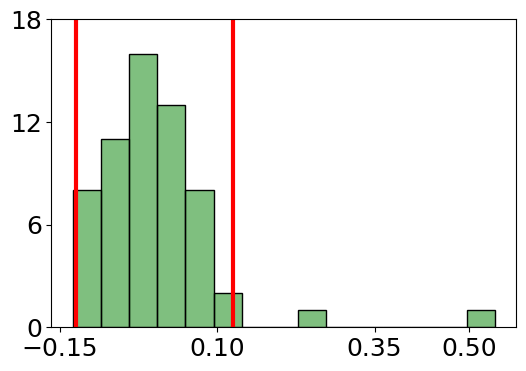

In [14]:
plt.figure(figsize=(6,4))

freeform_y_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(freeform,freeform_y))))
plt.style.use("default")

sns.histplot(freeform_diff['Y'], bins=15, color="green", alpha=0.5)
plt.axvline(x=3*freeform_y_sigma, lw=3, color="red")
plt.axvline(x=-3*freeform_y_sigma, lw=3, color="red")

plt.xticks(np.append(np.arange(-0.15, 0.51, step=0.25),0.5), fontsize=18)
plt.yticks(np.arange(0, 18.1, step=6), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("freeform_y_diff.png", bbox_inches='tight', dpi=1000)

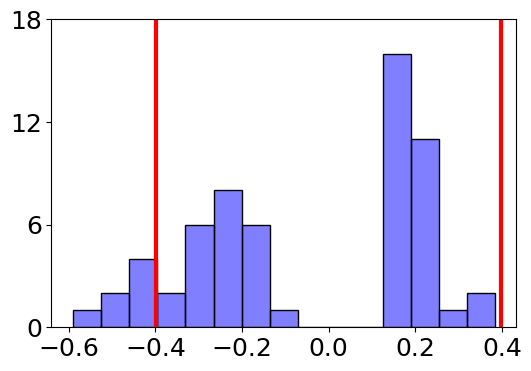

In [15]:
plt.figure(figsize=(6,4))

freeform_z_sigma = np.sqrt(np.max(np.exp(mbelm_pred_ensemble(freeform,freeform_z))))
plt.style.use("default")

sns.histplot(freeform_diff['Z'], bins=15, color="blue", alpha=0.5)
plt.axvline(x=3*freeform_z_sigma, lw=3, color="red")
plt.axvline(x=-3*freeform_z_sigma, lw=3, color="red")

plt.xticks(np.arange(-0.6, 0.41, step=0.2), fontsize=18)
plt.yticks(np.arange(0, 18.1, step=6), fontsize=18)
plt.xlabel("")
plt.ylabel("")

plt.savefig("freeform_z_diff.png", bbox_inches='tight', dpi=1000)